In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

# DataFrame con los datos proporcionados
datos = {
    'Años': [1996, 1997, 1998, 1999, 2000, 2001,
             2002, 2003, 2004, 2005, 2006],

    'dC/dt': [2.012868, 2.018041, 2.011465,
              1.991033, 1.954632, 1.900352,
              1.826780, 1.733348, 1.620728,
              1.491151, 1.348516],

    'dY/dt': [0.000564, 0.001196, 0.001188,
              0.000411, -0.001265, -0.003958,
              -0.007749, -0.012658, -0.018615,
              -0.025434, -0.032812],

    'dL/dt': [0.006130, 0.007304, 0.008639,
              0.010113, 0.011671, 0.013223,
              0.014625, 0.015694, 0.016215,
              0.015983, 0.014853],

    'C': [60.275818, 60.585464, 60.581082,
          60.200853, 59.381690, 58.064814,
          56.203817, 53.774927, 50.788154,
          47.296728, 43.401188],

    'Y': [2.043051, 2.043615, 2.044811,
          2.045999, 2.046410, 2.045145,
          2.041188, 2.033442, 2.020791,
          2.002188, 1.976774],

    'L': [0.033794, 0.039927, 0.047232,
          0.055869, 0.065974, 0.077632,
          0.090829, 0.105417, 0.121060,
          0.137209, 0.153116]
}

df = pd.DataFrame(datos)

In [ ]:
# Modelo de Rosenzweig-MacArthur
def rosenzweig_macarthur(y, t, r_C, K, a_CY, h_CY, a_CL, h_CL, r_Y, e_CY, r_L, e_CL):
    C, Y, L = y
    dCdt = r_C * C * (1 - C / K) - a_CY * C * Y / (1 + h_CY * C) - a_CL * C * L / (1 + h_CL * C)
    dYdt = -r_Y * Y + e_CY * a_CY * C * Y / (1 + h_CY * C)
    dLdt = -r_L * L + e_CL * a_CL * C * L / (1 + h_CL * C)
    return [dCdt, dYdt, dLdt]

# Función objetivo para la optimización (minimizar suma de errores cuadrados SSE)
def objetivo_rosenzweig(params):
    solucion = odeint(rosenzweig_macarthur, condiciones_iniciales, df['Años'], args=tuple(params))
    C_pred, Y_pred, L_pred = solucion.T
    error = np.sum((df['C'] - C_pred)**2) + np.sum((df['Y'] - Y_pred)**2) + np.sum((df['L'] - L_pred)**2)
    return error

# Establecer rangos de parámetros (r_C, K, a_CY, h_CY, a_CL, h_CL, r_Y, e_CY, r_L, e_CL)
rangos_rosenzweig = [(0.001, 1), (50, 150), (0.001, 1), (0.001, 1), (0.001, 1),
                     (0.001, 1), (0.001, 1), (0.001, 1), (0.001, 1), (0.001, 1)]

# Condiciones iniciales (población inicial)
condiciones_iniciales = [df['C'].iloc[0], df['Y'].iloc[0], df['L'].iloc[0]]

# Parámetros iniciales para L-BFGS-B
params0_rosenzweig = [0.2, 100, 0.4, 0.2, 0.4, 0.2, 1, 0.01, 1, 0.01]

# Tiempo de integración (1996-2196)
t_integracion = np.linspace(1996, 2196, 200)

# Optimización de parámetros con límites
resultado_rosenzweig = minimize(objetivo_rosenzweig, params0_rosenzweig,
                                method='L-BFGS-B', bounds=rangos_rosenzweig)
mejores_params = resultado_rosenzweig.x

# Solución del sistema con los mejores parámetros
solucion_rosenzweig = odeint(rosenzweig_macarthur, condiciones_iniciales,
                             t_integracion, args=tuple(mejores_params))
C_sol, Y_sol, L_sol = solucion_rosenzweig.T

# Valor de la función objetivo para los mejores parámetros
valor_objetivo_rosenzweig = resultado_rosenzweig.fun

mejores_params, valor_objetivo_rosenzweig

(array([1.42415866e-01, 8.95505354e+01, 4.75097928e-01, 8.76068498e-01,
        9.98852407e-01, 1.06226996e-02, 4.56592765e-01, 8.56438647e-01,
        3.55900968e-01, 1.53701308e-02]),
 0.011677614983300038)

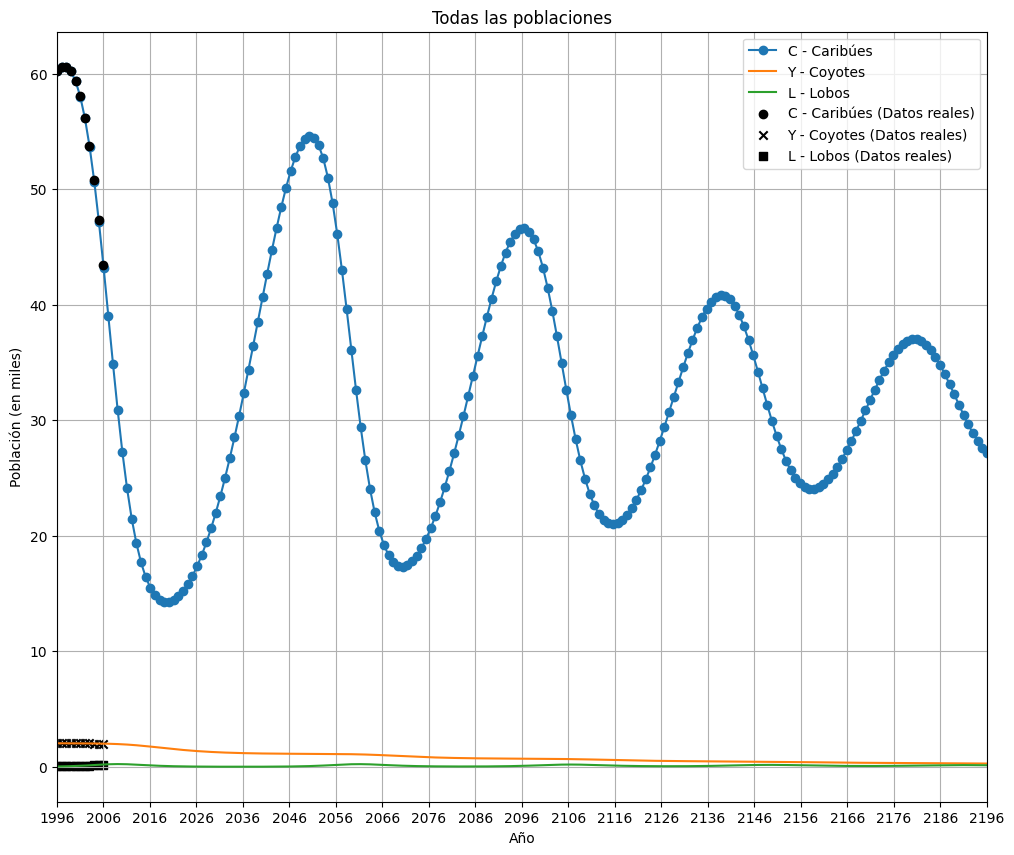

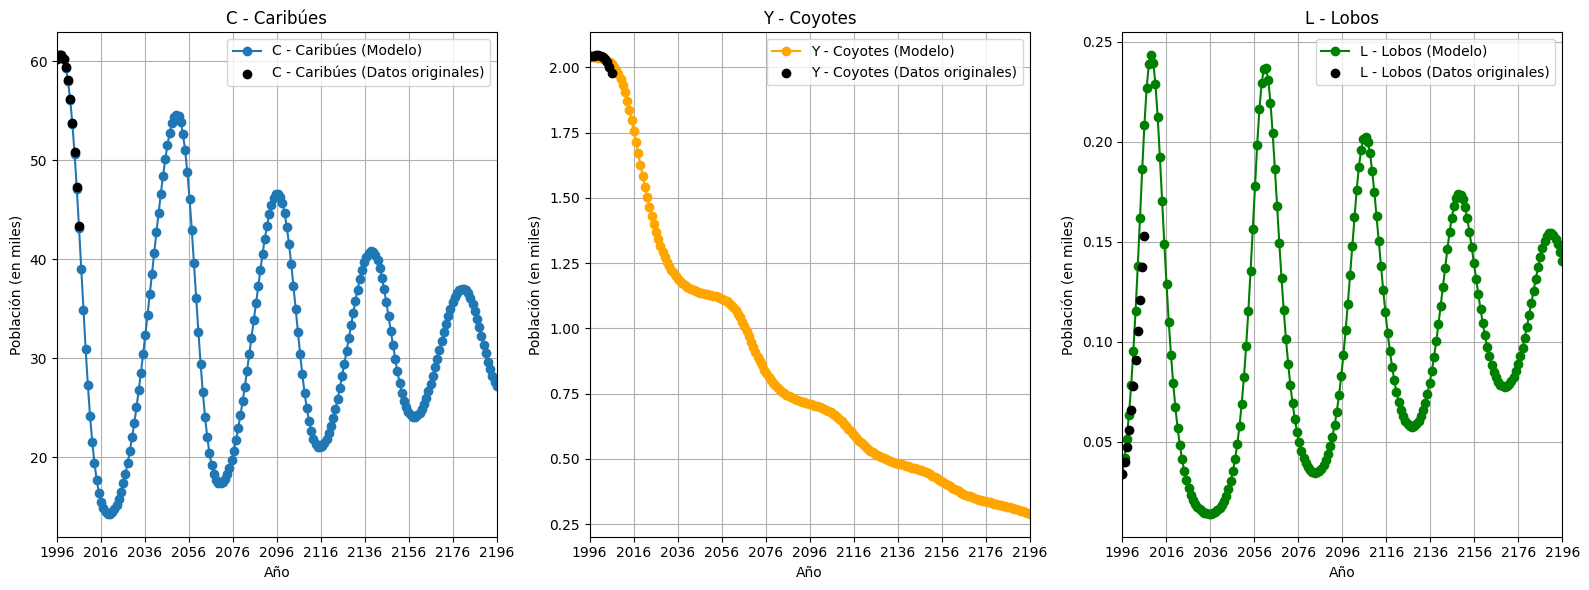

In [ ]:
# Plot de todas las poblaciones
plt.figure(figsize=(12, 10))
plt.plot(t_integracion, C_sol, label='C - Caribúes', marker='o')
plt.plot(t_integracion, Y_sol, label='Y - Coyotes')
plt.plot(t_integracion, L_sol, label='L - Lobos')
plt.scatter(df['Años'], df['C'], c='k', marker='o', label='C - Caribúes (Datos reales)', zorder=5)
plt.scatter(df['Años'], df['Y'], c='k', marker='x', label='Y - Coyotes (Datos reales)')
plt.scatter(df['Años'], df['L'], c='k', marker='s', label='L - Lobos (Datos reales)')
plt.title('Todas las poblaciones')
plt.xlabel('Año')
plt.ylabel('Población (en miles)')
plt.legend()
plt.grid(True)
plt.xlim(1996, 2196)
plt.xticks(np.arange(1996, 2197, 10))
plt.show()

# Subplots para cada especie
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
especies = [(C_sol, 'C - Caribúes','o', 'tab:blue', df['C']),
            (Y_sol, 'Y - Coyotes','o', 'orange', df['Y']),
            (L_sol, 'L - Lobos','o', 'g', df['L'])]
for ax, (data, label, marker, color, datos_originales) in zip(axs, especies):
    ax.plot(t_integracion, data, label=f'{label} (Modelo)', marker=marker, color=color)
    ax.scatter(df['Años'], datos_originales, color='k', label=f'{label} (Datos originales)', zorder=5)
    ax.set_title(label)
    ax.set_xlabel('Año')
    ax.set_ylabel('Población (en miles)')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(1996, 2196)
    ax.set_xticks(np.arange(1996, 2197, 20))

plt.tight_layout()
plt.show()

In [ ]:
# Estimar población en cierto año
def estimador(year, C_sol, Y_sol, L_sol, start_year=1996, end_year=2196):
    # Calcular el índice del año correspondiente
    indice = int((year - start_year) / (end_year - start_year) * (len(C_sol) - 1))

    C_poblacion = C_sol[indice]
    Y_poblacion = Y_sol[indice]
    L_poblacion = L_sol[indice]

    poblaciones = {
        'Año': year,
        'Caribú (C)': C_poblacion * 1000,
        'Coyote (Y)': Y_poblacion * 1000,
        'Lobo (L)': L_poblacion * 1000
    }

    return poblaciones

years = [1996, 2046, 2096, 2146, 2196]
estimado = [estimador(year, C_sol, Y_sol, L_sol) for year in years]

for pop in estimado:
    print(f"En el año {pop['Año']}:\n"
          f"  - Población de caribúes estimada: {pop['Caribú (C)']:.2f}\n"
          f"  - Población de coyotes estimada: {pop['Coyote (Y)']:.2f}\n"
          f"  - Población de lobos estimada: {pop['Lobo (L)']:.2f}\n")

En el año 1996:
  - Población de caribúes estimada: 60275.82
  - Población de coyotes estimada: 2043.05
  - Población de lobos estimada: 33.79

En el año 2046:
  - Población de caribúes estimada: 50085.26
  - Población de coyotes estimada: 1139.19
  - Población de lobos estimada: 30.18

En el año 2096:
  - Población de caribúes estimada: 46539.74
  - Población de coyotes estimada: 711.08
  - Población de lobos estimada: 82.69

En el año 2146:
  - Población de caribúes estimada: 35634.93
  - Población de coyotes estimada: 458.36
  - Población de lobos estimada: 162.05

En el año 2196:
  - Población de caribúes estimada: 27163.35
  - Población de coyotes estimada: 289.13
  - Población de lobos estimada: 140.59

